In [1]:
# ML_in_Finance-Bayesian-Neural-Network
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6.9 with the following packages:
# numpy=1.18.1, pymc3=3.8, theano=1.0.4, scikit-learn=0.22.1, seaborn=0.10.1, matplotlib=3.1.3
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., Halperin I. and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020.
# This notebook is adapted from a notebook written by Thomas Wiecki and Maxim Kochurov (2017):
# https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html?highlight=advi

# Generate data for a simple binary classification problem that's not linearly separable - the half-moon problem.

In [27]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.datasets import make_moons

In [28]:
X, Y = make_moons(noise=0.0, random_state=0, n_samples=100)
X = scale(X)

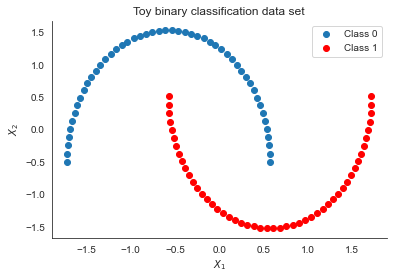

In [29]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='$X_1$', ylabel='$X_2$', title='Toy binary classification data set');

# Model specification

Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem. Std. Gaussian priors are specified for each weight

In [30]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X)
        ann_output = pm.Data('ann_output', Y)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X, Y)

# Variational Inference: Scaling model complexity

The following code uses ADVI, a variational inference algorithm in PyMC3. Note, that this is a mean-field approximation so we ignore correlations in the posterior.

In [31]:
conda install -c conda-forge theano-pymc

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [32]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.datasets import make_moons

In [33]:
from theano.sandbox.rng_mrg import MRG_RandomStream as RandomStream

In [34]:
from pymc3.theanof import set_tt_rng 

In [35]:
RandomStream = set_tt_rng(42)

In [36]:
%%time
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Finished [100%]: Average Loss = 53.376


Wall time: 5.93 s


Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.


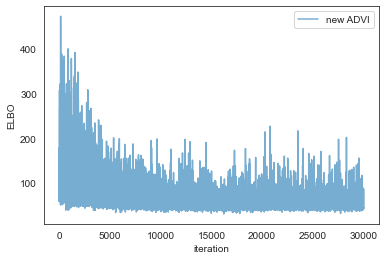

In [37]:
plt.plot(inference.hist, label='new ADVI', alpha=.6)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [38]:
trace = approx.sample(draws=5000)

 Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC).

We can use sample_posterior_predictive() <../api/inference.rst>__ to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation). It is faster to get the node directly and build the theano graph using our approximation (approx.sample_node).

In [39]:
# create symbolic input for lazy evaluation
x = T.matrix('X')

# symbolic number of samples is supported
n = T.iscalar('n')

# Do not forget test_value or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

In [40]:
sample_proba(X, 500)

array([[0.12440125, 0.88363828, 0.84228891, ..., 0.85825297, 0.59979812,
        0.14072342],
       [0.10933042, 0.89047113, 0.87626207, ..., 0.89072199, 0.52066788,
        0.12176713],
       [0.27887587, 0.69290019, 0.52966197, ..., 0.81129137, 0.8453824 ,
        0.54141819],
       ...,
       [0.10076234, 0.89403462, 0.87753091, ..., 0.88988925, 0.14598286,
        0.1180668 ],
       [0.07516974, 0.89301955, 0.84253217, ..., 0.93634397, 0.55666284,
        0.18457776],
       [0.11678377, 0.85049157, 0.71754901, ..., 0.86892448, 0.51632448,
        0.32226642]])

In [41]:
pred = sample_proba(X, 500).mean(0) > 0.5

In [42]:
pred.shape

(100,)

In [43]:
print('Accuracy = {}%'.format((Y == pred).mean() * 100))

Accuracy = 88.0%


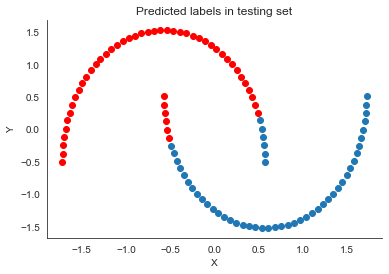

In [44]:
fig, ax = plt.subplots()
ax.scatter(X[pred==True, 0], X[pred==True, 1])
ax.scatter(X[pred==False, 0], X[pred==False, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [45]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [46]:
ppc = sample_proba(grid_2d ,500)

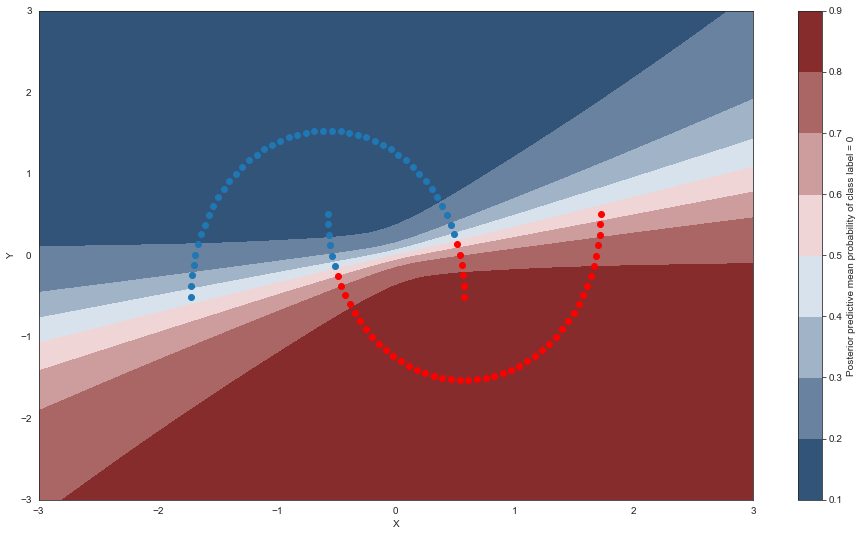

In [47]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[pred==0, 0], X[pred==0, 1])
ax.scatter(X[pred==1, 0], X[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

# Uncertainty in predicted value

 The standard deviation of the posterior predictive characterizes the uncertainty in the predictions.

# cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[pred==0, 0], X[pred==0, 1])
ax.scatter(X[pred==1, 0], X[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

 We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. To reduce uncertainty, we might want to train the model primarily on samples from that high-uncertainty region.

# Diagnostics

# Plot the posteriors of the Neural Network weights.

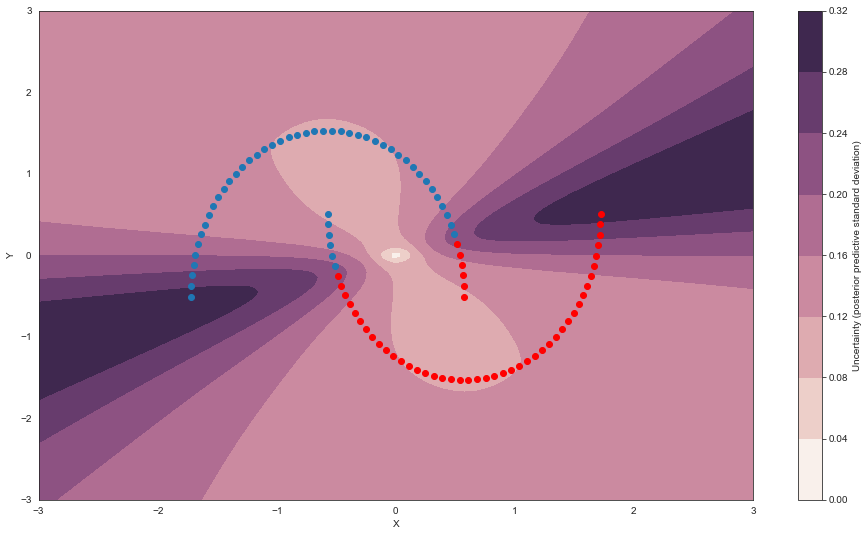

In [50]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X[pred==0, 0], X[pred==0, 1])
ax.scatter(X[pred==1, 0], X[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [51]:
filterwarnings('ignore')
pm.traceplot(trace);

AttributeError: module 'pymc3' has no attribute 'traceplot'

In [52]:
conda install -c conda-forge theano-pymc3.traceplot

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.

Note: you may need to restart the kernel to use updated packages.



PackagesNotFoundError: The following packages are not available from current channels:

  - theano-pymc3.traceplot

Current channels:

  - https://conda.anaconda.org/conda-forge/win-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [53]:
filterwarnings('ignore')
pm.traceplot(trace);

AttributeError: module 'pymc3' has no attribute 'traceplot'

In [54]:
conda install pymc3

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\josep\anaconda3

  added / updated specs:
    - pymc3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pymc3-3.8                  |             py_0         694 KB
    theano-1.0.4               |           py38_0         3.2 MB
    ------------------------------------------------------------
                                           Total:         3.9 MB

The following NEW packages will be INSTALLED:

  theano             pkgs/main/win-64::theano-1.0.4-py38_0

The following packages will be SUPERSEDED by a higher-priority channel:

  conda              conda-forge::conda-4.9.2-py38haa244fe~ --> pkgs/main::conda-4.9.2-py38haa95532_0
  pymc3              conda-forge::pymc3-3.11.1-pyhd8ed1ab_0 --> pkgs/main::pymc3-3.8-py_0




theano-1.0.4         | 3.2 MB    |            |   0% 
theano-1.0.4   

In [55]:
filterwarnings('ignore')
pm.traceplot(trace);

AttributeError: module 'pymc3' has no attribute 'traceplot'

In [56]:
import pymc3 as pm

In [57]:
basic_model = pm.Model()

In [65]:
filterwarnings('ignore')
pm.Model(trace);

In [67]:
 pm.traceplot(trace)

AttributeError: module 'pymc3' has no attribute 'traceplot'

In [69]:
pip install arviz

Note: you may need to restart the kernel to use updated packages.


In [71]:
filterwarnings('ignore')
pm.traceplot(trace);

AttributeError: module 'pymc3' has no attribute 'traceplot'

In [72]:
conda install -c conda-forge arviz

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\josep\anaconda3

  added / updated specs:
    - arviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arviz-0.11.2               |     pyhd8ed1ab_0         1.4 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.4 MB

The following packages will be UPDATED:

  arviz                                 0.11.1-pyhd8ed1ab_0 --> 0.11.2-pyhd8ed1ab_0

The following packages will be SUPERSEDED by a higher-priority channel:

  conda               pkgs/main::conda-4.9.2-py38haa95532_0 --> conda-forge::conda-4.9.2-py38haa244fe_0




arviz-0.11.2         | 1.4 MB    |            |   0% 
arviz-0.11.2         | 1.4 MB    | 1          |   1% 
arviz-0.11.2         | 1.4 MB    | 5          |   6% 
Note: you may need to restar

In [74]:
filterwarnings('ignore')
pm.plot(trace);

AttributeError: module 'pymc3' has no attribute 'plot'

In [75]:
import arviz as az

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C9CBE83F70>,
      dtype=object)

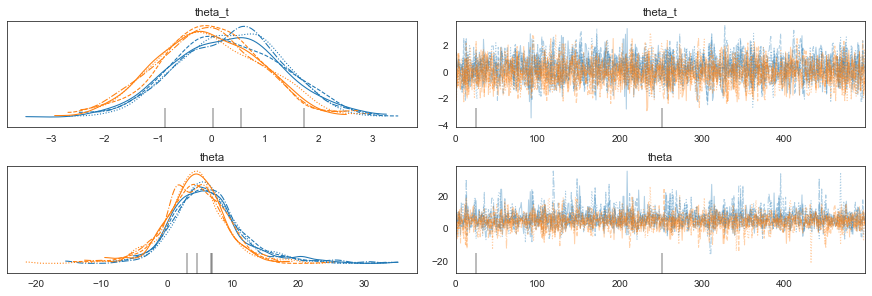

In [76]:
data = az.load_arviz_data('non_centered_eight')
coords = {'school': ['Choate', 'Lawrenceville']}
az.plot_trace(data, var_names=('theta'), filter_vars="like", coords=coords)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C9D0FFA820>,
      dtype=object)

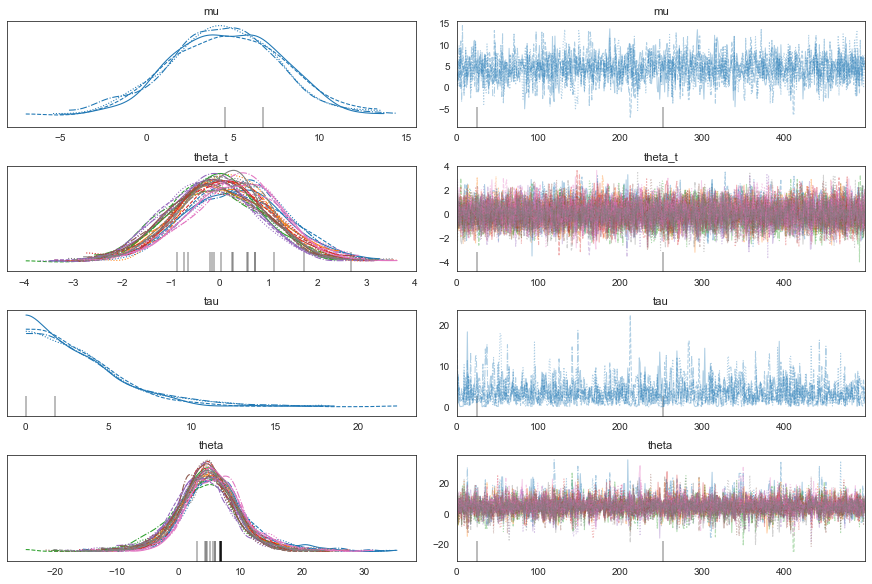

In [77]:
az.plot_trace(data, compact=True)

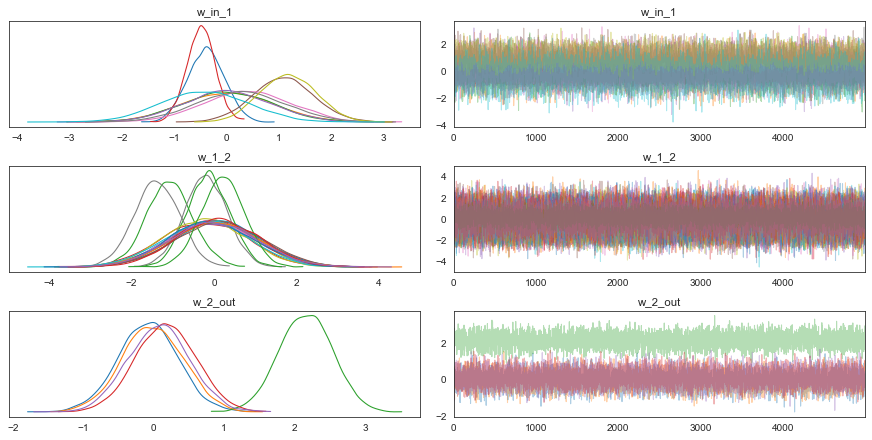

In [79]:
filterwarnings('ignore')
az.plot_trace(trace);